# **epileptic seizures detection in EEG signals - second assignment**

### **ABSTRAT**

##### Epilepsy, a brain disease generally associated with seizures, has tremendous effects on people’s quality of life. Diagnosis of epileptic seizures is commonly performed on electroencephalography (EEG) signals, and by using computer-aided diagnosis systems (CADS), neurologists can diagnose epileptic seizure stages more accurately.

##### In these systems, a mandatory stage is feature extraction, performed by handcrafting features or learning them, ordinarily by a deep neural net. While researches in this field commonly show the value of a group of limited features, yet an accurate comparison between different suggested features is essential.

##### in this notebook we will:
1. select the best features using ID3 and corrolation by using f1 score
2. improve our model using clustering
3. evaluating other problems with improved model and normal model

## Imports

In [170]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
import pickle
from scipy.signal import butter, lfilter
from sklearn.svm import SVC

import random
import os
# my imports#############################
import scipy.stats as stats
from matplotlib import pyplot as plt
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
%matplotlib inline
import seaborn as sns; 
sns.set()  # for plot styling
from sklearn import tree


## setting seed

In [171]:
seed = 57
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed) 

# Loading Data

In [172]:
x = pickle.load(open('x.pkl', 'rb'))
y = pickle.load(open('y.pkl', 'rb'))

x_normal = np.concatenate((x[:300], x[400:]), axis=0)
x_seizure = x[300:400]

sampling_freq = 173.6 #based on info from website
b, a = butter(3, [0.5,40], btype='bandpass',fs=sampling_freq)
x_normal_filtered = np.array(\
    [lfilter(b,a,x_normal[ind,:]) for ind in range(x_normal.shape[0])])
x_seizure_filtered = np.array(\
    [lfilter(b,a,x_seizure[ind,:]) for ind in range(x_seizure.shape[0])])

x_normal = x_normal_filtered
x_seizure = x_seizure_filtered

x = np.concatenate((x_normal,x_seizure))
y = np.concatenate((np.zeros((400,1)),np.ones((100,1))))

# Feature extracting and Normalization

In [173]:
Min = []; Max = []; Mean = []; Rms = []; Var = []; Std = []
mean_square = []; Peak = []; Skew = []; Kurtosis = []; P2p = []
CrestFactor = []; FormFactor = []; PulseIndicator = []
ShapeFactor = []; MAbs = []; Smr = []; ImpulseFactor =[]
ClearanceFactor = []
for data in x:
    #Time Domain - Dimensional Parameters
    Min.append(np.min(data)) #minimum                                                       1
    Max.append(np.max(data)) #maximum                                                       2
    Mean.append(np.mean(data)) #mean                                                        3
    Rms.append(np.sqrt(np.mean((data)**2))) #root-mean-square                               4
    Smr.append((np.mean(np.sqrt(np.abs(data))))**2) #square-mean-root                       5
    Var.append(np.var(data)) #variance                                                      6
    Std.append(np.std(data)) # standard deviation                                           7
    mean_square.append(np.mean((data)**2)) #mean square                                     8
    MAbs.append(np.mean(np.abs(data))) #mean-abslute                                        9
    Peak.append(np.max(np.abs(data))) #peak                                                 10
    P2p.append(np.ptp(data)) #peak to peak                                                  11

    #Time Domain - Dimensional Parameters
    CrestFactor.append(np.max(np.abs(data))/np.sqrt(np.mean((data)**2))) #crest Factor      12
    Skew.append(stats.skew(data)) #skewness                                                 13
    Kurtosis.append(stats.kurtosis(data)) #kurtosis                                         14
    FormFactor.append(np.sqrt(np.mean((data)**2))/np.mean((data))) #form factor             15
    PulseIndicator.append(np.max(np.abs(data))/np.mean(data)) #Pulse Indicator              16
    ShapeFactor.append((np.sqrt(np.mean((data)**2)))/(np.mean(np.abs(data)))) #Shape Factor 17
    ImpulseFactor.append((np.max(np.abs(data)))/(np.mean(np.abs(data))))#                   18
    ClearanceFactor.append((np.max(np.abs(data)))/((np.mean(np.sqrt(np.abs(data))))**2))#   19

x_fft = np.fft.fft(x)
x_ps = np.abs(x_fft**2)/len(x)

Max_f = []; Sum_f = []; Mean_f = []; Var_f = []; Peak_f = []
Skew_f = []; Kurtosis_f = []

for data in x_ps:
    #Frequency-domain
    Max_f.append(np.max(data))#                                                          20
    Sum_f.append(np.sum(data))#                                                          21
    Mean_f.append(np.mean(data))#                                                        22
    Var_f.append(np.var(data))#                                                          23
    Peak_f.append(np.max(np.abs(data)))#                                                 24
    Kurtosis_f.append(stats.kurtosis(data))#                                             25
    Skew_f.append(stats.skew(data)) #                                                    26

features = list(zip(Min, Max, Mean, Rms, Var, Std, mean_square, Peak, Skew, Kurtosis, P2p, \
                   CrestFactor, FormFactor, PulseIndicator, ShapeFactor, MAbs, Smr, ImpulseFactor,  \
                   ClearanceFactor, Max_f, Sum_f, Mean_f, Var_f, Peak_f, Skew_f, Kurtosis_f))
feature_name = ['Min', 'Max', 'Mean', 'Rms', 'Var', 'Std', 'mean_square', 'Peak', 'Skew', 'Kurtosis', 'P2p', \
                   'CrestFactor', 'FormFactor', 'PulseIndicator', 'ShapeFactor', 'MAbs', 'Smr', 'ImpulseFactor',  \
                   'ClearanceFactor', 'Max_f', 'Sum_f', 'Mean_f', 'Var_f', 'Peak_f', 'Skew_f', 'Kurtosis_f']
                   
features = np.asarray(features, dtype=object)

normal_features = []
scaler = StandardScaler() 
features_StandardScaler_col = np.zeros_like(features)
for i in range(len(features[0])):features_StandardScaler_col[:, i] = scaler.fit_transform(features[:, i].reshape(-1, 1)).flatten()

# feature selection
#### In machine learning and statistics, feature selection, also known as variable selection, attribute selection, or variable subset selection.  Feature Selection can be defined as the problem of **selecting a minimal-size subset of the variables that collectively (multi-varietally) contain all predictive information necessary to produce an optimally** predictive model for a target variable (outcome) of interest.

#### Thus, the goal of the feature selection task is to filter out the irrelevant or redundant variables given the ones already selected and **select only the ones providing collectively unique information for the outcome of interest leading to an optimal predictive model in terms of performance**.

<div><img src="fs_filter.png" width="500"/></div>

### Advantages of using feature selection

##### - By removing irrelevant and redundant features, the **“job”** of the modeling algorithm is getting **easier** and thus often leads to **better final models**. Less ambiguous data means **improvement of modeling accuracy**.
##### - Another advantage of getting easier the task of the learning algorithm is that its **training time becomes shorter** and **uses fewer resources** (e.g., memory). This is because a good selection of features facilitates modeling, particularly for algorithms susceptible to the **curse of dimensionality**.
##### - **Decreases over-fitting**: Less redundant data means **less chances of making decisions based on noise**.
##### - Finally, an important aspect of feature selection is the **cost optimization** that a user can achieve by using a model with fewer features. This is especially important if it is **very expensive to measure certain features**, and each feature is associated with a cost.
<div><img src="fs_adv.png" width="700"/></div>

## Disadvantages of feature selection

##### - **The feature selection problem is NP-hard**. There are several approaches to solve the problem exactly (also called the best subset selection problem) only for linear models. Although the results are promising, exact approaches are only able to handle a few hundred or thousand variables at most (so, they are not applicable on high dimensional data).

##### - most approaches rely on some kind of **approximation**. The majority of approximate approaches can be roughly categorized into:
-  *stepwise methods* such as FBED
- *sparsity-based methods* such as LASSO
- *information-theoretic methods* 
- *causal-based methods* 

##### Even though they are approximations and do not solve the exact problem, they are still **optimal for a large class of distributions** or **under certain conditions**.

##### - Unfortunately, it is often the case that the task of the **feature selection** per se is that **much slower** that diminishes the **benefit of the faster model training**. However, this can be optimized by caching the selected features and thus applying the feature selection only once.

##### - Another shortcoming  is that they arbitrarily seek to **identify only one solution to the problem**. However, in practice, it is often the case that multiple predictive or even information equivalent solutions exist. Especially in domains with inherent redundancy present in the underlying problem. Molecular biology is such a case where often multiple solutions exist.

[[ref1](https://www.aretove.com/importance-of-feature-selection-in-machine-learning)]
[[ref2](https://towardsdatascience.com/do-we-really-need-feature-selection-in-a-data-analysis-pipeline-dc8401621c6c)]

##### to select features, we use below metrics:
### 1 - How well each feature acts on its own

##### We have to calculate how much a feature can shows the distinction between datas. To do it, we use Decision Tree (ID3) classification and its recall as our metric.

#### What is a Decision Tree?
A Supervised Machine Learning Algorithm, used to build classification and regression models in the form of a tree structure.
- A decision tree is a tree where each -

    - Node - a feature(attribute)
    - Branch - a decision(rule)
    - Leaf - an outcome(categorical or continuous)

There are many algorithms to build decision trees, here we are going to discuss ID3 algorithm with an example.

#### **ID3**
ID3 algorithm, stands for **Iterative Dichotomiser 3**, is a **classification** algorithm that follows a **greedy approach** of building a decision tree by **selecting a best attribute that yields maximum Information Gain (IG) or minimum Entropy (H)**.

##### What is Entropy and Information gain?

Entropy is a measure of the amount of uncertainty in the dataset S. Mathematical Representation of Entropy is shown here -
<div><img src="id3-Ent.png" width="300"/></div>

Where :
- S - The current dataset for which entropy is being calculated(changes every iteration of the ID3 algorithm).
- C - Set of classes in S {example - C ={yes, no}}
- p(c) - The proportion of the number of elements in class c to the number of elements in set S.

In ID3, entropy is calculated for each remaining attribute. The attribute with the smallest entropy is used to split the set S on that particular iteration.

Entropy = 0 implies it is of pure class, that means all are of same category.

Information Gain IG(A) tells us how much uncertainty in S was reduced after splitting set S on attribute A. Mathematical representation of Information gain is shown here -

<div><img src="id3-IG.png" width="300"/></div>

Where

- H(S) - Entropy of set S.
- T - The subsets created from splitting set S by attribute A such that

<div><img src="id3-IG2.png" width="100"/></div>

- p(t) - The proportion of the number of elements in t to the number of elements in set S.
- H(t) - Entropy of subset t.

In ID3, information gain can be calculated (instead of entropy) for each remaining attribute. The attribute with the largest information gain is used to split the set S on that particular iteration.

<div><img src="id3.png" width="400"/></div>

[[ref](https://iq.opengenus.org/id3-algorithm/)]

#### score

our case is  seizure detection on a person, so if somebody is pationt and has seizure activity, we need to spot their illness avoiding the false negatives. A false negative patient may become threats to others or himself/herself. That’s why, when we have to spot an event that already occurred, so we want our model to spot as many real 1 as possible. we need to work with recall.

##### Recall

Recall is the fraction of correctly classified 1s among all the real 1s.

Recall is very used when you have to **correctly classify some event** that has **already occurred**. For example, fraud detection models must have a high recall in order to detect frauds properly. In such situations, we **don’t care** about the **real 0s**, because we are **interested** only in spotting the **real 1s** as often as possible. So, we’re working with the **second row of the confusion matrix.**

<div><img src="Recall.png" width="300"/></div> 

[[ref](https://www.yourdatateacher.com/2021/06/07/precision-recall-accuracy-how-to-choose/#:~:text=We%20can%20use%20accuracy%20when,many%20real%201%20as%20possible)]

### 2 - How different is each feature from the rest of features in general

One of the measures used for feature selection is dependency measures. Many dependency based methods have been proposed.
The main measure is Correlation based method. Pearson’s Correlation method is used for finding the association between the continuous features and the class feature 

Correlation is a well-known similarity measures between two features. If two features are linearly dependent, then their correlation coefficient is ±1. If the features are uncorrelated, the correlation coefficient is 0. The association between the features is found out by using the correlation method. There are two broad categories that can be used to measure the correlation between two random variables. One is based on classical linear correlation and the other is based on information theory. Out of these two, the most familiar measure is linear correlation coefficient. As per the standard literature, for a pair of variables (X, Y), the linear correlation coefficient ‘r’ is given by:

<div><img src="corr.png" width="300"/></div>

[[ref](https://journals.sagepub.com/doi/pdf/10.1260/1748-3018.6.3.385)]

## combinig to metrics using f1() score

The capabilities of any algorithm are gauged by a set of evaluation metrics, the most popular one being model accuracy. For a long time, accuracy was the only metric used for comparing machine learning models.

However, accuracy only computes how many times a model made a correct prediction across the entire dataset, which remains valid if the dataset is class-balanced.

F1 score is an alternative machine learning evaluation metric that assesses the predictive skill of a model by elaborating on its class-wise performance rather than an overall performance as done by accuracy. F1 score combines two competing metrics- precision and recall scores of a model, leading to its widespread use in recent literature.

The F1 score is calculated as the harmonic mean of the precision and recall scores, as shown below. It ranges from 0-100%, and a higher F1 score denotes a better quality classifier.

<div><img src="f1-s.png" width="450"/></div>

[[ref](https://www.v7labs.com/blog/f1-score-guide?Email-8=simpichsaman%40gmail.com)]

### the code :

we use k-fold cross validation with k=5 to calculate recall of each decision tree. it's bcs if we use k-fold cross validation, we will have more relable and trustable score than normal splliting.

after that we calculate recall for decision tree with depth of one and append it o recall list.

then we plot them: 


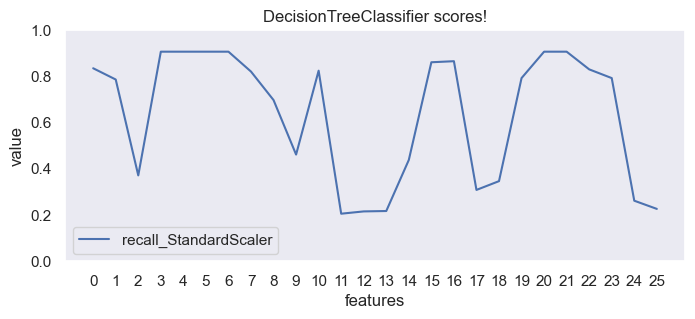

soreted features according to their recall:
 index         feature     recall score 
    4             Var         0.9072
    5             Std         0.9072
    6     mean_square         0.9072
   21          Mean_f         0.9072
   20           Sum_f         0.9072
    3             Rms         0.9072
   16             Smr          0.866
   15            MAbs         0.8614
    0             Min         0.8354
   22           Var_f         0.8307
   10             P2p          0.825
    7            Peak         0.8211
   19           Max_f         0.7929
   23          Peak_f         0.7929
    1             Max         0.7867
    8            Skew         0.6977
    9        Kurtosis         0.4619
   14     ShapeFactor         0.4386
    2            Mean         0.3716
   18 ClearanceFactor         0.3468
   17   ImpulseFactor         0.3088
   24          Skew_f         0.2621
   25      Kurtosis_f         0.2267
   13  PulseIndicator         0.2175
   12      FormFactor      

In [174]:
recall_StandardScaler = []
cv = KFold(n_splits=5, random_state=seed, shuffle=True)
model = tree.DecisionTreeClassifier(random_state=seed)

for i in range(1,27):
    this_feature_StS = features_StandardScaler_col[:,(i-1):i]
    recall_StandardScaler.append(np.mean(cross_val_score(model, this_feature_StS, y, scoring='recall', cv=cv, n_jobs=-1)))

sns.set(rc = {'figure.figsize':(8,3)})
plt.plot(range(0, 26), recall_StandardScaler, label = "recall_StandardScaler")
plt.xlabel('features')
plt.ylabel('value')
plt.title('DecisionTreeClassifier scores!')
plt.grid()
plt.legend()
plt.ylim(0.00, 1.00)
plt.xticks(range(0, 26)) 
plt.show()

idx=np.flip(np.argsort(recall_StandardScaler))
print("soreted features according to their recall:\n","index        ", "feature    ", "recall score ")
for indx in idx:
    print("{: >5}".format(indx), "{: >15}".format(feature_name[indx]), \
        "{: >14}".format(round(recall_StandardScaler[indx], 4)))

# How different is each feature from the rest of features in general

to calculate dependencies between features, we use *corroef*. 

*corroef* Returns Pearson product-moment correlation coefficients. The relationship between the correlation coefficient matrix, R, and the covariance matrix, C, is:
<div><img src="corroef_f.png" width="120"/></div> 
The values of R are between -1 and 1, inclusive.

[[ref](https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html)]

<AxesSubplot:>

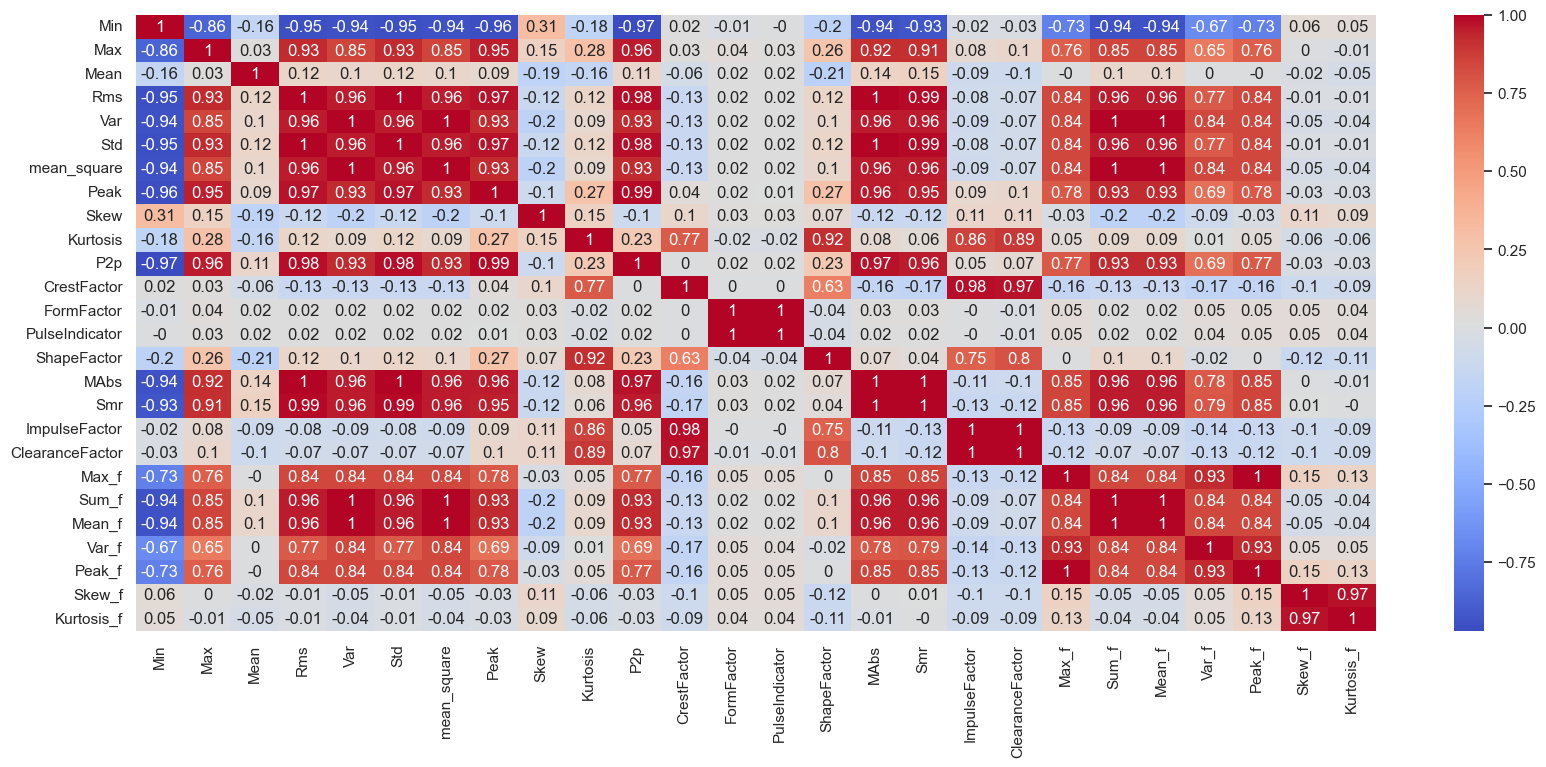

In [175]:
corr_matrix = np.corrcoef((features.astype(float)).T).round(decimals=2)
this_df = pd.DataFrame(corr_matrix, columns = feature_name, index = feature_name)
sns.set(rc = {'figure.figsize':(20,8)})
sns.heatmap(this_df, annot = True, fmt='.2g',cmap= 'coolwarm')

as you can see, some features have high dependency (corr near 1 and -1) with other features (e.g., mean_square, P2P, Smr) and some of them have low dependency with others (e.g., Skew_f, Kurosis_f, Pulseindicator).

## selecting features - algorithm

<div><img src="Untitled.png" width="600"/></div> 
steps:

- calulating recall from ID3 with depth=1 and sort them
- add feature with highest recall to selected features
- for n=2 in range 15 do 
   - for i in selected group
      - calulate corrolation i with all not-selected features
      - select max corrolation
      - normalize the corrolation
   - calculate f1 with recall and normalized corrolation of features
   - select feature with highest f1 and add it to selected features
   - calculate recall with selected feature and report it 
- choose best "selected feature" according to recalls

## selecting features - code

to find best "selected features", we declare a *for loop* with *n in range(2,len(features[0]))*. it will calculate recall with the selected features.

the first feature will be appended to the selected list according to the recalls calculated in ID3. so we append its index to selected list and remove it from non-selected list by assign it with -1.

after that we used a while loop to find next best feature that we need to add to our selected list. we use a whille loop to find the next index of not-selected feature and assign it to pointer varable.

now we use a while loop to calculate f1 of selected features and not-selected features. 

to find max corrolation with selected list, we declare a for loop and calculate absolute value of corrolation between i selected and not-selected features.

after that we choose highest corrolation and normalize it by subtracting it from 1.

agter that we calculate f1 and append it to our list.

then we sort our list and selecte feature with highest f1 score.

now we check the recall of the selected feature and report it if it's higher that 0.95 . the reason why we use 0.95 is totally experimental. 

In [176]:
best_rec = [[],[],[],[],[],[]]
best_rec_fidx = [[],[],[],[],[],[]]
counter = 0

for n in range(1,len(features[0])): # from 2 to 26 features
    
    selected_f = []
    not_selected_f = np.arange(0,len(features[0]))
    selected_f.append(idx[0]) #choosing best feature according to its recall in ID3
    not_selected_f[idx[0]] = -1 
    
    while(len(selected_f)<=n): # we calculate f1 until number of selected features reachs to n  
        pointer = 0
        while(not_selected_f[pointer] == -1): pointer += 1 # finding next not-selected feature

        not_calcf1 = not_selected_f.copy() # creating a numpy array to find the maximum f1
        
        f1_list = []; f1_list_idx = []
        while(not(np.all(not_calcf1 == -1))):
            sf_crr_list =[]
            for i in selected_f: # finding max corrolation to calculate max f1
                sf_crr_list.append(np.abs(np.corrcoef(features[:,i].astype(float), features[:,pointer].astype(float))[0,1]))
            selected_f_maxcrr = 1 - max(sf_crr_list) # if |corr| -> 1    :     high dependency
                                                     # if |corr| -> 0    :     low dependency
                                                     # so to find better faeture, we do 1 - maxcorr   

            f1 = (2 * (selected_f_maxcrr * recall_StandardScaler[pointer])) / (selected_f_maxcrr + recall_StandardScaler[pointer]) # calculating f1
            
            f1_list.append(f1)
            f1_list_idx.append(pointer)
            not_calcf1[pointer] = -1

            while((not_calcf1[pointer] == -1) & (pointer < 25)): pointer += 1

        idx_best_f1=f1_list_idx[(np.flip(np.argsort(f1_list)))[0]]
        selected_f.append(idx_best_f1)

    
    b_f = []
    for i in selected_f:
        b_f.append(features_StandardScaler_col[:, i:(i+1)]) # separating selected feature from others
    b_f_np = (np.squeeze(np.array(b_f))).T

    cv = KFold(n_splits=5, random_state=seed, shuffle=True)
    model =RandomForestClassifier(random_state=seed, n_estimators=100) # calculating recal with selected feature using k-fold k=5
    recall_best_f = np.mean(cross_val_score(model, b_f_np, y, scoring='recall', cv=cv, n_jobs=-1, error_score='raise'))
    
    if(recall_best_f > 0.95) : 
        print(' selected features: ', [feature_name[name] for name in selected_f ])
        print('selected features count: ', len(b_f_np[0]),'   recall by k-fold 5 : ', np.round(recall_best_f, 4), '\n')

        best_rec[counter].append(recall_best_f)
        best_rec_fidx[counter].append(selected_f)
        counter += 1


 selected features:  ['Var', 'Skew', 'Kurtosis', 'Mean', 'Skew_f', 'PulseIndicator', 'Var_f', 'Max', 'CrestFactor', 'ShapeFactor']
selected features count:  10    recall by k-fold 5 :  0.9511 

 selected features:  ['Var', 'Skew', 'Kurtosis', 'Mean', 'Skew_f', 'PulseIndicator', 'Var_f', 'Max', 'CrestFactor', 'ShapeFactor', 'Peak_f', 'Min', 'Smr', 'Peak', 'ClearanceFactor', 'Kurtosis_f', 'P2p', 'Rms', 'ImpulseFactor', 'FormFactor', 'MAbs', 'mean_square', 'Std']
selected features count:  23    recall by k-fold 5 :  0.9501 

 selected features:  ['Var', 'Skew', 'Kurtosis', 'Mean', 'Skew_f', 'PulseIndicator', 'Var_f', 'Max', 'CrestFactor', 'ShapeFactor', 'Peak_f', 'Min', 'Smr', 'Peak', 'ClearanceFactor', 'Kurtosis_f', 'P2p', 'Rms', 'ImpulseFactor', 'FormFactor', 'MAbs', 'mean_square', 'Std', 'Smr', 'Smr', 'Smr']
selected features count:  26    recall by k-fold 5 :  0.9511 



as you can see, by using only 10 features, we reached the best recall score. the selected features are :
- Var
- Skew
- Kurtosis
- Mean
- Skew_f
- PulseIndicator
- Var_f
- Max
- CrestFactor
- ShapeFactor

now that selecte our feature, let's see which features have high dependency with them. we use a threshhold to find out if two features are similar or not.

In [177]:
selected_features = []
selected_f_idx = np.squeeze(np.array(best_rec_fidx[0], dtype=int)).tolist()
corr_treshhold = 0.8

cv = KFold(n_splits=5, random_state=seed, shuffle=True)
model =RandomForestClassifier(random_state=seed, n_estimators=100)

for i in selected_f_idx: selected_features.append(features_StandardScaler_col[:, i:(i+1)])

selected_features_np = (np.squeeze(np.array(selected_features))).T

recall_best_f = cross_val_score(model, selected_features_np, y, scoring='recall', cv=cv, n_jobs=-1, error_score='raise')

for j in range(0, len(selected_f_idx)):
    my_list = []
    print('selected feature name : ', feature_name[selected_f_idx[j]])
    for i in range(0, 26):
        corr = (np.abs(np.corrcoef(features[:,i].astype(float), features[:,selected_f_idx[j]].astype(float))[0,1]))
        if((corr> corr_treshhold) & (i != selected_f_idx[j])):
            my_list.append(i)
    print(f'ther are <{len(my_list)}> similar features with corr more than treshhold={corr_treshhold} : ', [feature_name[name] for name in my_list ])

selected feature name :  Var
ther are <14> similar features with corr more than treshhold=0.8 :  ['Min', 'Max', 'Rms', 'Std', 'mean_square', 'Peak', 'P2p', 'MAbs', 'Smr', 'Max_f', 'Sum_f', 'Mean_f', 'Var_f', 'Peak_f']
selected feature name :  Skew
ther are <0> similar features with corr more than treshhold=0.8 :  []
selected feature name :  Kurtosis
ther are <3> similar features with corr more than treshhold=0.8 :  ['ShapeFactor', 'ImpulseFactor', 'ClearanceFactor']
selected feature name :  Mean
ther are <0> similar features with corr more than treshhold=0.8 :  []
selected feature name :  Skew_f
ther are <1> similar features with corr more than treshhold=0.8 :  ['Kurtosis_f']
selected feature name :  PulseIndicator
ther are <1> similar features with corr more than treshhold=0.8 :  ['FormFactor']
selected feature name :  Var_f
ther are <6> similar features with corr more than treshhold=0.8 :  ['Var', 'mean_square', 'Max_f', 'Sum_f', 'Mean_f', 'Peak_f']
selected feature name :  Max
ther 

# improving model by using clustering


Classification and clustering algorithms have been proved to be successful individually in different contexts. Both of them have their own advantages and limitations. For instance, although classification algorithms are more powerful than clustering methods in predicting class labels of objects, they do not perform well when there is a lack of sufficient manually labeled reliable data. On the other hand, although clustering algorithms do not produce label information for objects, they provide supplementary constraints (e.g., if two objects are clustered together, it is more likely that the same label is assigned to both of them) that one can leverage for label prediction of a set of unknown objects. Therefore, systematic utilization of both these types of algorithms together can lead to better prediction performance.

[[ref1](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjji42Dtdb8AhWFxIsKHa8KAu8QFnoECAwQAQ&url=http%3A%2F%2Fwww.ijcse.net%2Fdocs%2FIJCSE16-05-06-026.pdf&usg=AOvVaw1ZzdgXHlkIximcdvcWLZdi)] (Combining Clustering with Classification: A Technique to Improve Classification Accuracy)

[[ref2](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjXwbe3ttb8AhUmx4sKHS4wBy4QFnoECA8QAQ&url=https%3A%2F%2Farxiv.org%2Fpdf%2F1708.08591&usg=AOvVaw10IYPf4kjYI57VFOCPCJnz)]  (EC3: Combining Clustering and Classification for Ensemble Learning)

[[ref3](https://www.google.com/search?client=firefox-b-d&q=J.+Gao%2C+F.+Liang%2C+W.+Fan%2C+Y.+Sun%2C+and+J.+Han%2C+%E2%80%9CA+graph-based+consensus+maximization+approach+for+combining+multiple+supervised+and+unsupervised+models%2C%E2%80%9D+IEEE+TKDE%2C+vol.+25%2C+no.+1%2C+pp.+15%E2%80%9328%2C+2013.)] (A Graph-Based Consensus Maximization Approach for Combining Multiple Supervised and Unsupervised Models)

[[ref4](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwia566nuNb8AhUJqIsKHRuhAggQFnoECAgQAQ&url=https%3A%2F%2Fkd.nsfc.gov.cn%2FpaperDownload%2F1000008855481.pdf&usg=AOvVaw0XW_kH5sPa4ewg45eRBQ4S)] (Combining supervised and unsupervised models via
unconstrained probabilistic embedding)

# how we combine them?

first we use k-means to cluster our train datas. each cluster becomes a new train dataset for classification. also we create new test data set according to predict of cluster.

after that we classify each segment with Random forest and then calculate the recall of whole segments according to their weights.


In [178]:
x_train, x_test, y_train, y_test = train_test_split(selected_features_np,y,random_state=seed,test_size=0.2)

k_limit = 6
for i in range (1, k_limit+1):
    x_train_clusterd = [[], [], [], [], [], []]
    y_train_clusterd = [[], [], [], [], [], []]
    x_test_clusterd = [[], [], [], [], [], []]
    y_test_clusterd = [[], [], [], [], [], []]
    recall_cluster = [] 
    k = i
    
    if(k!=1):
        print('k = ', k)
        kmeans = KMeans(n_clusters=k, random_state=seed).fit(x_train)
        
        y_pred_train = kmeans.labels_
        for i in range(0, k): # creating train segments according to lables from clusters for train datas
            for j in range(0, len(y_pred_train)):
                if(y_pred_train[j] == i): 
                    x_train_clusterd[i].append(x_train[j, :])
                    y_train_clusterd[i].append(y_train[j, :])

        y_labels_test = kmeans.predict(x_test)
        for i in range(0, k): # creating test segments according to lables predicted by cluster for test datas
            for j in range(0, len(y_labels_test)):
                if(y_pred_train[j] == i): 
                    x_test_clusterd[i].append(x_test[j, :])
                    y_test_clusterd[i].append(y_test[j, :])
    else:
        print('k = ', k, ' it means normal classification without clustering')
        x_train_clusterd[0] = x_train
        y_train_clusterd[0] = y_train
        x_test_clusterd [0] = x_test
        y_test_clusterd [0] = y_test 


    model = RandomForestClassifier(random_state=seed, n_estimators=100)

    Optimal_data_count = 0
    weight_cluster = []
    for i in range(0, k):
        x_clusterd = np.asarray(x_train_clusterd[i], dtype=float)
        y_clusterd = np.asarray(y_train_clusterd[i], dtype=int)
        x_test_cluste = np.asarray(x_test_clusterd[i], dtype=float)
        y_test_cluste = np.asarray(y_test_clusterd[i], dtype=int)

        one = np.count_nonzero((y_clusterd))
        zero = len(y_clusterd) - one
        if((k <= len(x_train_clusterd[i]))):
            model.fit(X=x_clusterd, y=y_clusterd.ravel())
            y_pred = model.predict(x_test_cluste)
            recall_cluster.append(recall_score(y_true=y_test_cluste, y_pred=y_pred))
            weight_cluster.append(len(x_train_clusterd[i])+len(x_test_clusterd[i]))
        else:
            recall_cluster.append(0.5)
            weight_cluster.append(0)
        
        # print('cluster train data : ', len(x_train_clusterd[i]), '   cluster test data : ', len(x_test_clusterd[i]), '  cluster labale : ', i)
        # print('lable 0 : ', zero, '   lable 1 : ', one)
        # print('recall_cluster : ', recall_cluster[i], '   weight : ', weight_cluster[i])
        
    print('recall of clusters : ', np.round(recall_cluster, 4))
    avg_recall = 0
    for i in range(0, k):
        avg_recall += (weight_cluster[i])*(recall_cluster[i])
        Optimal_data_count += weight_cluster[i]

    print('AVG recall of clusters : ', np.round(avg_recall/Optimal_data_count, 4), '  Optimal data count : ', Optimal_data_count)

k =  1  it means normal classification without clustering
recall of clusters :  [0.9231]
AVG recall of clusters :  0.9231   Optimal data count :  500
k =  2
recall of clusters :  [0.9545 1.    ]
AVG recall of clusters :  0.9599   Optimal data count :  500
k =  3
recall of clusters :  [0.9545 1.     1.    ]
AVG recall of clusters :  0.9595   Optimal data count :  500
k =  4
recall of clusters :  [1.     0.9545 1.     0.5   ]
AVG recall of clusters :  0.9595   Optimal data count :  497
k =  5
recall of clusters :  [0.9524 1.     1.     0.5    0.5   ]
AVG recall of clusters :  0.8816   Optimal data count :  497
k =  6
recall of clusters :  [0.95 1.   0.5  1.   0.5  1.  ]
AVG recall of clusters :  0.8841   Optimal data count :  497


as you can see, can see, with k=2, K=3 and k=4 we have highest recall and it improves our model from 0.92 recall to 0.96 recal (almost 4%)

# checking combination of clustering and classification with other problems  


### finding Seizure activity in patient group:
   1.   A -> patients with seizure free (recorded from within the epileptogenic zone)
   2.   B -> patients with seizure free (recorded from the hippocampal formation of the opposite hemisphere of the brain)
   3.   E -> patients with **Seizure activity**


In [179]:
selected_features_np_ABE = np.zeros((300,10))
Y_np_ABE = np.zeros((300,1))
selected_features_np_ABE[:200, :] = selected_features_np[:200, :]
selected_features_np_ABE[200:, :] = selected_features_np[400:, :]
Y_np_ABE[:200, :] = y[:200, :]
Y_np_ABE[200:, :] = y[400:, :]

x_train, x_test, y_train, y_test = train_test_split(selected_features_np_ABE,Y_np_ABE,random_state=seed,test_size=0.2)

k_limit = 6
for i in range(1, k_limit+1):
    x_train_clusterd = [[], [], [], [], [], []]
    y_train_clusterd = [[], [], [], [], [], []]
    x_test_clusterd = [[], [], [], [], [], []]
    y_test_clusterd = [[], [], [], [], [], []]
    recall_cluster = []
    k = i

    if(k!=1):
        print('k = ', k)
        kmeans = KMeans(n_clusters=k, random_state=seed).fit(x_train)
        
        y_pred_train = kmeans.labels_
        for i in range(0, k): # creating train segments according to lables from clusters for train datas
            for j in range(0, len(y_pred_train)):
                if(y_pred_train[j] == i): 
                    x_train_clusterd[i].append(x_train[j, :])
                    y_train_clusterd[i].append(y_train[j, :])

        y_labels_test = kmeans.predict(x_test)
        for i in range(0, k): # creating test segments according to lables predicted by cluster for test datas
            for j in range(0, len(y_labels_test)):
                if(y_pred_train[j] == i): 
                    x_test_clusterd[i].append(x_test[j, :])
                    y_test_clusterd[i].append(y_test[j, :])
    else:
        print('k = ', k, ' it means normal classification without clustering')
        x_train_clusterd[0] = x_train
        y_train_clusterd[0] = y_train
        x_test_clusterd [0] = x_test
        y_test_clusterd [0] = y_test 


    model = RandomForestClassifier(random_state=seed, n_estimators=100)
    Optimal_data_count = 0
    weight_cluster = []
    
    for i in range(0, k):
        x_clusterd = np.asarray(x_train_clusterd[i], dtype=float)
        y_clusterd = np.asarray(y_train_clusterd[i], dtype=int)
        x_test_cluste = np.asarray(x_test_clusterd[i], dtype=float)
        y_test_cluste = np.asarray(y_test_clusterd[i], dtype=int)
        one = np.count_nonzero((y_clusterd))
        zero = len(y_clusterd) - one
        if((k <= len(x_train_clusterd[i]))):
            model.fit(X=x_clusterd, y=y_clusterd.ravel())
            y_pred = model.predict(x_test_cluste)
            recall_cluster.append(recall_score(y_true=y_test_cluste, y_pred=y_pred, zero_division=0))
            weight_cluster.append(len(x_train_clusterd[i])+len(x_test_clusterd[i]))
        else:
            recall_cluster.append(0.5)
            weight_cluster.append(0)
        
        # print('cluster train data : ', len(x_train_clusterd[i]), '   cluster test data : ', len(x_test_clusterd[i]), '  cluster labale : ', i)
        # print('lable 0 : ', zero, '   lable 1 : ', one)
        # print('recall_cluster : ', recall_cluster[i], '   weight : ', weight_cluster[i])
        
    print('recall of clusters : ', np.round(recall_cluster, 4))
    avg_recall = 0
    for i in range(0, k):
        avg_recall += (weight_cluster[i])*(recall_cluster[i])
        Optimal_data_count += weight_cluster[i]

    print('AVG recall of clusters : ', np.round(avg_recall/Optimal_data_count, 4), '  Optimal data count : ', Optimal_data_count)

k =  1  it means normal classification without clustering
recall of clusters :  [0.9474]
AVG recall of clusters :  0.9474   Optimal data count :  300
k =  2
recall of clusters :  [1.     0.8824]
AVG recall of clusters :  0.898   Optimal data count :  300
k =  3
recall of clusters :  [0.9375 1.     0.    ]
AVG recall of clusters :  0.895   Optimal data count :  300
k =  4
recall of clusters :  [0.     1.     1.     0.7143]
AVG recall of clusters :  0.7524   Optimal data count :  300
k =  5
recall of clusters :  [0.5    0.9333 1.     1.     0.    ]
AVG recall of clusters :  0.9045   Optimal data count :  298
k =  6
recall of clusters :  [1.  1.  0.  1.  0.5 0. ]
AVG recall of clusters :  0.9097   Optimal data count :  299


according to the reports, best recall calculated when we didn't used clustering and only used classification in this problem.

### finding Seizure activity in Healthy group:
   1.   C -> Healthy cases with Eye close
   2.   D -> Healthy cases with Eye open
   3.   E -> patients with **Seizure activity**

In [180]:
selected_features_np_CDE = np.zeros((300,10))
Y_np_CDE = np.zeros((300,1))
selected_features_np_CDE[:200, :] = selected_features_np[200:400, :]
selected_features_np_CDE[200:, :] = selected_features_np[400:, :]
Y_np_CDE[:200, :] = y[200:400, :]
Y_np_CDE[200:, :] = y[400:, :]
x_train, x_test, y_train, y_test = train_test_split(selected_features_np_CDE,Y_np_CDE,random_state=seed,test_size=0.2)

k_limit = 6
for i in range(1, k_limit+1):
    x_train_clusterd = [[], [], [], [], [], []]
    y_train_clusterd = [[], [], [], [], [], []]
    x_test_clusterd = [[], [], [], [], [], []]
    y_test_clusterd = [[], [], [], [], [], []]
    recall_cluster = []
    k = i

    if(k!=1):
        print('k = ', k)
        kmeans = KMeans(n_clusters=k, random_state=seed).fit(x_train)
        
        y_pred_train = kmeans.labels_
        for i in range(0, k): # creating train segments according to lables from clusters for train datas
            for j in range(0, len(y_pred_train)):
                if(y_pred_train[j] == i): 
                    x_train_clusterd[i].append(x_train[j, :])
                    y_train_clusterd[i].append(y_train[j, :])

        y_labels_test = kmeans.predict(x_test)
        for i in range(0, k): # creating test segments according to lables predicted by cluster for test datas
            for j in range(0, len(y_labels_test)):
                if(y_pred_train[j] == i): 
                    x_test_clusterd[i].append(x_test[j, :])
                    y_test_clusterd[i].append(y_test[j, :])
    else:
        print('k = ', k, ' it means normal classification without clustering')
        x_train_clusterd[0] = x_train
        y_train_clusterd[0] = y_train
        x_test_clusterd [0] = x_test
        y_test_clusterd [0] = y_test 

    model = RandomForestClassifier(random_state=seed, n_estimators=100)
    Optimal_data_count = 0
    weight_cluster = []
    
    for i in range(0, k):
        x_clusterd = np.asarray(x_train_clusterd[i], dtype=float)
        y_clusterd = np.asarray(y_train_clusterd[i], dtype=int)
        x_test_cluste = np.asarray(x_test_clusterd[i], dtype=float)
        y_test_cluste = np.asarray(y_test_clusterd[i], dtype=int)
        one = np.count_nonzero((y_clusterd))
        zero = len(y_clusterd) - one
        if((k <= len(x_train_clusterd[i]))):
            model.fit(X=x_clusterd, y=y_clusterd.ravel())
            y_pred = model.predict(x_test_cluste)
            recall_cluster.append(recall_score(y_true=y_test_cluste, y_pred=y_pred, zero_division=0))
            weight_cluster.append(len(x_train_clusterd[i])+len(x_test_clusterd[i]))
        else:
            recall_cluster.append(0.5)
            weight_cluster.append(0)
        
        # print('cluster train data : ', len(x_train_clusterd[i]), '   cluster test data : ', len(x_test_clusterd[i]), '  cluster labale : ', i)
        # print('lable 0 : ', zero, '   lable 1 : ', one)
        # print('recall_cluster : ', recall_cluster[i], '   weight : ', weight_cluster[i])
        
    print('recall of clusters : ', np.round(recall_cluster, 4))
    avg_recall = 0
    for i in range(0, k):
        avg_recall += (weight_cluster[i])*(recall_cluster[i])
        Optimal_data_count += weight_cluster[i]

    print('AVG recall of clusters : ', np.round(avg_recall/Optimal_data_count, 4), '  Optimal data count : ', Optimal_data_count)

k =  1  it means normal classification without clustering
recall of clusters :  [1.]
AVG recall of clusters :  1.0   Optimal data count :  300
k =  2
recall of clusters :  [1. 1.]
AVG recall of clusters :  1.0   Optimal data count :  300
k =  3
recall of clusters :  [1. 1. 1.]
AVG recall of clusters :  1.0   Optimal data count :  300
k =  4
recall of clusters :  [0. 1. 1. 1.]
AVG recall of clusters :  0.9633   Optimal data count :  300
k =  5
recall of clusters :  [1. 1. 1. 0. 1.]
AVG recall of clusters :  0.9633   Optimal data count :  300
k =  6
recall of clusters :  [1. 1. 0. 1. 1. 0.]
AVG recall of clusters :  0.73   Optimal data count :  300


as you can see, there is no improvment in using cluster + classification in this problem.

### separating patients with seizure free from Healthy group:
   1. A -> patients with seizure free (recorded from within the epileptogenic zone)
   2. B -> patients with seizure free (recorded from the hippocampal formation of the opposite hemisphere of the brain)
   3. C -> Healthy cases with Eye close
   4. D -> Healthy cases with Eye open 

In [181]:
selected_features_np_ABCD = np.zeros((400,10))
Y_np_ABCD = np.zeros((400,1))
selected_features_np_ABCD[:400, :] = selected_features_np[:400, :]
Y_np_ABCD[:200, :] = 0
Y_np_ABCD[200:400, :] = 1

x_train, x_test, y_train, y_test = train_test_split(selected_features_np_ABCD,Y_np_ABCD,random_state=seed,test_size=0.2)

k_limit = 6
for i in range(1, k_limit+1):
    x_train_clusterd = [[], [], [], [], [], []]
    y_train_clusterd = [[], [], [], [], [], []]
    x_test_clusterd = [[], [], [], [], [], []]
    y_test_clusterd = [[], [], [], [], [], []]
    recall_cluster = []
    k = i

    if(k!=1):
        print('k = ', k)
        kmeans = KMeans(n_clusters=k, random_state=seed).fit(x_train)
        
        y_pred_train = kmeans.labels_
        for i in range(0, k): # creating train segments according to lables from clusters for train datas
            for j in range(0, len(y_pred_train)):
                if(y_pred_train[j] == i): 
                    x_train_clusterd[i].append(x_train[j, :])
                    y_train_clusterd[i].append(y_train[j, :])

        y_labels_test = kmeans.predict(x_test)
        for i in range(0, k): # creating test segments according to lables predicted by cluster for test datas
            for j in range(0, len(y_labels_test)):
                if(y_pred_train[j] == i): 
                    x_test_clusterd[i].append(x_test[j, :])
                    y_test_clusterd[i].append(y_test[j, :])
    else:
        print('k = ', k, ' it means normal classification without clustering')
        x_train_clusterd[0] = x_train
        y_train_clusterd[0] = y_train
        x_test_clusterd [0] = x_test
        y_test_clusterd [0] = y_test 

    model = RandomForestClassifier(random_state=seed, n_estimators=100)
    Optimal_data_count = 0
    weight_cluster = []
    
    for i in range(0, k):
        x_clusterd = np.asarray(x_train_clusterd[i], dtype=float)
        y_clusterd = np.asarray(y_train_clusterd[i], dtype=int)
        x_test_cluste = np.asarray(x_test_clusterd[i], dtype=float)
        y_test_cluste = np.asarray(y_test_clusterd[i], dtype=int)
        one = np.count_nonzero((y_clusterd))
        zero = len(y_clusterd) - one
        if((k <= len(x_train_clusterd[i]))):
            model.fit(X=x_clusterd, y=y_clusterd.ravel())
            y_pred = model.predict(x_test_cluste)
            recall_cluster.append(recall_score(y_true=y_test_cluste, y_pred=y_pred, zero_division=0))
            weight_cluster.append(len(x_train_clusterd[i])+len(x_test_clusterd[i]))
        else:
            recall_cluster.append(0.5)
            weight_cluster.append(0)
        
        # print('cluster train data : ', len(x_train_clusterd[i]), '   cluster test data : ', len(x_test_clusterd[i]), '  cluster labale : ', i)
        # print('lable 0 : ', zero, '   lable 1 : ', one)
        # print('recall_cluster : ', recall_cluster[i], '   weight : ', weight_cluster[i])
        
    print('recall of clusters : ', np.round(recall_cluster, 4))
    avg_recall = 0
    for i in range(0, k):
        avg_recall += (weight_cluster[i])*(recall_cluster[i])
        Optimal_data_count += weight_cluster[i]

    print('AVG recall of clusters : ', np.round(avg_recall/Optimal_data_count, 4), '  Optimal data count : ', Optimal_data_count)

k =  1  it means normal classification without clustering
recall of clusters :  [0.7143]
AVG recall of clusters :  0.7143   Optimal data count :  400
k =  2
recall of clusters :  [0.7317 0.    ]
AVG recall of clusters :  0.7098   Optimal data count :  400
k =  3
recall of clusters :  [0.697 0.    0.875]
AVG recall of clusters :  0.6988   Optimal data count :  400
k =  4
recall of clusters :  [0.7273 0.     0.5    0.875 ]
AVG recall of clusters :  0.7243   Optimal data count :  399
k =  5
recall of clusters :  [0.875  0.     0.8182 0.5    0.5   ]
AVG recall of clusters :  0.8028   Optimal data count :  397
k =  6
recall of clusters :  [0.5769 0.     0.3333 0.6667 0.5    0.5   ]
AVG recall of clusters :  0.5595   Optimal data count :  397


according to the reports, the highest recall calculated when k=5 in this problem.

In [182]:
selected_features_np_ABCDE = np.zeros((500,10))
selected_features_np_ABCDE[:,:] = selected_features_np[:,:]
Y_np_ABCDE = np.zeros((500,1))
Y_np_ABCDE[:200, :] = 0
Y_np_ABCDE[200:400, :] = 1
Y_np_ABCDE[400:, :] = 2

x_train, x_test, y_train, y_test = train_test_split(selected_features_np_ABCDE,Y_np_ABCDE,random_state=seed,test_size=0.2)

k_limit = 9
for i in range(1, k_limit+1):
    x_train_clusterd = [[], [], [], [], [], [], [], [], []]
    y_train_clusterd = [[], [], [], [], [], [], [], [], []]
    x_test_clusterd = [[], [], [], [], [], [], [], [], []]
    y_test_clusterd = [[], [], [], [], [], [], [], [], []]
    recall_cluster = []
    k = i

    if(k!=1):
        print('k = ', k)
        kmeans = KMeans(n_clusters=k, random_state=seed).fit(x_train)
        
        y_pred_train = kmeans.labels_
        for i in range(0, k): # creating train segments according to lables from clusters for train datas
            for j in range(0, len(y_pred_train)):
                if(y_pred_train[j] == i): 
                    x_train_clusterd[i].append(x_train[j, :])
                    y_train_clusterd[i].append(y_train[j, :])

        y_labels_test = kmeans.predict(x_test)
        for i in range(0, k): # creating test segments according to lables predicted by cluster for test datas
            for j in range(0, len(y_labels_test)):
                if(y_pred_train[j] == i): 
                    x_test_clusterd[i].append(x_test[j, :])
                    y_test_clusterd[i].append(y_test[j, :])
    else:
        print('k = ', k, ' it means normal classification without clustering')
        x_train_clusterd[0] = x_train
        y_train_clusterd[0] = y_train
        x_test_clusterd [0] = x_test
        y_test_clusterd [0] = y_test 

    model = RandomForestClassifier(random_state=seed, n_estimators=100)
    Optimal_data_count = 0
    weight_cluster = []
    
    for i in range(0, k):
        x_clusterd = np.asarray(x_train_clusterd[i], dtype=float)
        y_clusterd = np.asarray(y_train_clusterd[i], dtype=int)
        x_test_cluste = np.asarray(x_test_clusterd[i], dtype=float)
        y_test_cluste = np.asarray(y_test_clusterd[i], dtype=int)
        one = np.count_nonzero((y_clusterd == 1))
        two = np.count_nonzero((y_clusterd == 2))
        zero = len(y_clusterd) - one - two
        if((k <= len(x_train_clusterd[i]))):
            model.fit(X=x_clusterd, y=y_clusterd.ravel())
            y_pred = model.predict(x_test_cluste)
            recall_cluster.append(recall_score(y_true=y_test_cluste, y_pred=y_pred, zero_division=0, average='micro'))
            weight_cluster.append(len(x_train_clusterd[i])+len(x_test_clusterd[i]))
        else:
            recall_cluster.append(0.5)
            weight_cluster.append(0)
        
        # print('cluster train data : ', len(x_train_clusterd[i]), '   cluster test data : ', len(x_test_clusterd[i]), '  cluster labale : ', i)
        # print('lable 0 : ', zero, '   lable 1 : ', one, '   lable 2 : ', two)
        # print('recall_cluster : ', recall_cluster[i], '   weight : ', weight_cluster[i], '\n')

    print('recall of clusters : ', np.round(recall_cluster, 4))
    avg_recall = 0
    for i in range(0, k):
        avg_recall += (weight_cluster[i])*(recall_cluster[i])
        Optimal_data_count += weight_cluster[i]
    print('AVG recall of clusters : ', np.round(avg_recall/Optimal_data_count, 4), '  Optimal data count : ', Optimal_data_count)

k =  1  it means normal classification without clustering
recall of clusters :  [0.84]
AVG recall of clusters :  0.84   Optimal data count :  500
k =  2
recall of clusters :  [0.8276 0.3077]
AVG recall of clusters :  0.7662   Optimal data count :  500
k =  3
recall of clusters :  [0.8182 0.3333 0.3333]
AVG recall of clusters :  0.7658   Optimal data count :  500
k =  4
recall of clusters :  [0.3333 0.7931 0.3333 0.5   ]
AVG recall of clusters :  0.7431   Optimal data count :  497
k =  5
recall of clusters :  [0.7945 0.3333 0.25   0.375  0.5   ]
AVG recall of clusters :  0.674   Optimal data count :  497
k =  6
recall of clusters :  [0.7917 0.25   0.5    0.4    0.4667 0.3333]
AVG recall of clusters :  0.689   Optimal data count :  497
k =  7
recall of clusters :  [0.8028 0.25   0.5    0.5    0.4667 0.3333 0.25  ]
AVG recall of clusters :  0.6868   Optimal data count :  497
k =  8
recall of clusters :  [0.3333 0.25   0.5    0.4667 0.5    0.3333 0.7143 0.5   ]
AVG recall of clusters :  0.

as you can see, there is no improvment in using cluster + classification in this problem.